In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
import dgl
import dgl.data

/Users/lidongyang/Desktop/Ph.D. 2nd yr/GDE/gde-master/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## 1. Data

In [27]:
dataset = dgl.data.CoraGraphDataset()
data = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [28]:
# Cora is a node-classification datasets with 2708 nodes
X = torch.FloatTensor(data.ndata['feat']).to(device)
Y = torch.LongTensor(data.ndata['label']).to(device)

# In transductive semi-supervised node classification tasks on graphs, the model has access to all
# node features but only a masked subset of the labels
train_mask = torch.BoolTensor(data.ndata['train_mask'])
val_mask = torch.BoolTensor(data.ndata['val_mask'])
test_mask = torch.BoolTensor(data.ndata['test_mask'])

num_feats = X.shape[1]
n_classes = dataset.num_classes

# 140 training samples, 300 validation, 1000 test
n_classes, train_mask.sum().item(), val_mask.sum().item(),test_mask.sum().item()

(7, 140, 500, 1000)

In [29]:
g = data.to(torch.device(device))
g = dgl.add_self_loop(g)
g.num_edges()

13264

In [30]:
# compute diagonal of normalization matrix D according to standard formula
degs = g.in_degrees().float()
norm = torch.pow(degs, -0.5)
norm[torch.isinf(norm)] = 0
# add to dgl.Graph in order for the norm to be accessible at training time
g.ndata['norm'] = norm.unsqueeze(1).to(device)

## 2. Model

In [31]:
import math
import numpy as np
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from typing import Callable
from torchdiffeq import odeint

In [32]:
class GCNLayer(nn.Module):
    def __init__(self, g:dgl.DGLGraph, in_feats:int, out_feats:int, activation:Callable[[torch.Tensor], torch.Tensor],
                 dropout:int, bias:bool=True):
        super().__init__()
        self.g = g
        self.weight = nn.Parameter(torch.Tensor(in_feats, out_feats))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_feats))
        else:
            self.bias = None
        self.activation = activation
        if dropout:
            self.dropout = nn.Dropout(p=dropout)
        else:
            self.dropout = 0.
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, h):
        if self.dropout:
            h = self.dropout(h)
        h = torch.mm(h, self.weight)
        # normalization by square root of src degree
        h = h * self.g.ndata['norm']
        self.g.ndata['h'] = h
        self.g.update_all(fn.copy_u('h', 'm'),
                          fn.sum(msg='m', out='h'))
        h = self.g.ndata.pop('h')
        # normalization by square root of dst degree
        h = h * self.g.ndata['norm']
        # bias
        if self.bias is not None:
            h = h + self.bias
        if self.activation:
            h = self.activation(h)
        return h

class GCNfunc(nn.Module):
  def __init__(self, g:dgl.DGLGraph, in_feats:int, out_feats:int, activation:Callable[[torch.Tensor], torch.Tensor],
            method:str):
    super(GCNfunc,self).__init__()

    self.hidden_layers = torch.nn.ModuleList()

    if method == 'dopri5':
      self.hidden_layers.append(GCNLayer(g,in_feats, out_feats, activation, dropout = 0.9))
    else:
      self.hidden_layers.append(GCNLayer(g,in_feats, out_feats, activation, dropout = 0.9))
      self.hidden_layers.append(GCNLayer(g,in_feats, out_feats, activation = None, dropout = 0.9))

  def forward(self,t,h):
    for i in range(len(self.hidden_layers)):
      h = self.hidden_layers[i](h)
    return h



class GCDE(nn.Module):
  def __init__(self, g:dgl.DGLGraph, in_feats:int, hidden_feats:int, out_feats:int, activation:Callable[[torch.Tensor], torch.Tensor]
               , method:str,s:int, rtol:float=1e-3, atol:float=1e-4):
    super(GCDE, self).__init__()


    self.method = method
    self.integration_time = torch.tensor([0, s]).float().to(device)
    self.rtol = rtol
    self.atol = atol


    self.input_layer = GCNLayer(g,in_feats, hidden_feats, F.relu, dropout = 0.6)

    self.odefunc = GCNfunc(g,hidden_feats,hidden_feats,activation,method)

    self.output_layer = GCNLayer(g,hidden_feats,out_feats, activation = None, dropout = 0)


  def forward(self,h):
    h = self.input_layer(h)
    h = odeint(self.odefunc, h, self.integration_time,rtol=self.rtol, atol=self.atol, method=self.method)[-1]
    h = self.output_layer(h)

    return h


In [33]:
model = GCDE(g, num_feats, 64, n_classes, nn.Softplus(), method='rk4', s=1).to(device)

In [34]:
for name, param in model.named_parameters():
    print(f"Name: {name}, Value: {param}, Shape: {param.shape}")

Name: input_layer.weight, Value: Parameter containing:
tensor([[ 0.1128, -0.0823, -0.0194,  ...,  0.0014, -0.0597,  0.0683],
        [-0.0736, -0.0440, -0.0484,  ...,  0.0316, -0.1219,  0.0348],
        [ 0.1037,  0.0174, -0.0398,  ...,  0.0708, -0.0249, -0.0480],
        ...,
        [-0.0413, -0.0887, -0.1188,  ...,  0.0384, -0.0842,  0.0798],
        [ 0.0976, -0.0108,  0.0151,  ..., -0.1041,  0.0107,  0.1224],
        [ 0.0926,  0.0017, -0.0621,  ...,  0.0418,  0.0093,  0.0352]],
       requires_grad=True), Shape: torch.Size([1433, 64])
Name: input_layer.bias, Value: Parameter containing:
tensor([-0.0323, -0.1230,  0.1013,  0.0302, -0.0178,  0.0070, -0.0084,  0.0523,
         0.0412,  0.0755, -0.0778,  0.0688,  0.0216, -0.0526, -0.1191, -0.0557,
         0.0419,  0.1249, -0.0411, -0.0891,  0.0937,  0.0265, -0.0247,  0.1169,
         0.0558,  0.0470,  0.0378, -0.0630, -0.0337, -0.0533, -0.0538, -0.0126,
        -0.1113, -0.0118,  0.0992, -0.0280, -0.0076,  0.0332, -0.0099,  0.0164,


## 3. Training

In [35]:
def accuracy(y_hat,y): # evaluation metric
  preds = torch.max(y_hat, 1)[1]
  return torch.mean((y == preds).float())

In [36]:
opt = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

steps = 3000
verbose_step = 15
num_grad_steps = 0

loss_history = []

train_acc_history = []
val_acc_history = []
test_acc_history = []

In [37]:


for i in range(steps): # looping over epochs
    model.train()

    outputs = model(X) 

    y_pred = outputs

    loss = criterion(y_pred[train_mask], Y[train_mask])
    loss_history.append(loss.item())
    
    opt.zero_grad()

    loss.backward()
    
    opt.step()
    num_grad_steps += 1

    with torch.no_grad():
        model.eval()
        y_pred = model(X)
       
        val_acc = accuracy(y_pred[val_mask], Y[val_mask]).item()
        train_acc = accuracy(y_pred[train_mask], Y[train_mask]).item()
        test_acc = accuracy(y_pred[test_mask], Y[test_mask]).item()

        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        test_acc_history.append(test_acc)


    if num_grad_steps % verbose_step == 0:
       print('[{}], Loss: {:3.3f},train accuracy: {:3.3f},validation accuracy: {:3.3f},test accuracy: {:3.3f}'.format(num_grad_steps,loss.item(),train_acc,val_acc,test_acc))

[15], Loss: 1.941,train accuracy: 0.264,validation accuracy: 0.168,test accuracy: 0.167
[30], Loss: 1.692,train accuracy: 0.421,validation accuracy: 0.176,test accuracy: 0.205
[45], Loss: 1.454,train accuracy: 0.907,validation accuracy: 0.670,test accuracy: 0.705
[60], Loss: 1.150,train accuracy: 0.921,validation accuracy: 0.732,test accuracy: 0.791
[75], Loss: 0.895,train accuracy: 0.943,validation accuracy: 0.746,test accuracy: 0.791
[90], Loss: 0.767,train accuracy: 0.936,validation accuracy: 0.702,test accuracy: 0.724
[105], Loss: 0.632,train accuracy: 0.943,validation accuracy: 0.742,test accuracy: 0.770
[120], Loss: 0.578,train accuracy: 0.957,validation accuracy: 0.728,test accuracy: 0.756
[135], Loss: 0.787,train accuracy: 0.971,validation accuracy: 0.724,test accuracy: 0.733
[150], Loss: 0.624,train accuracy: 0.979,validation accuracy: 0.762,test accuracy: 0.780
[165], Loss: 0.643,train accuracy: 0.979,validation accuracy: 0.746,test accuracy: 0.762
[180], Loss: 0.464,train ac

## 4. Results and plots

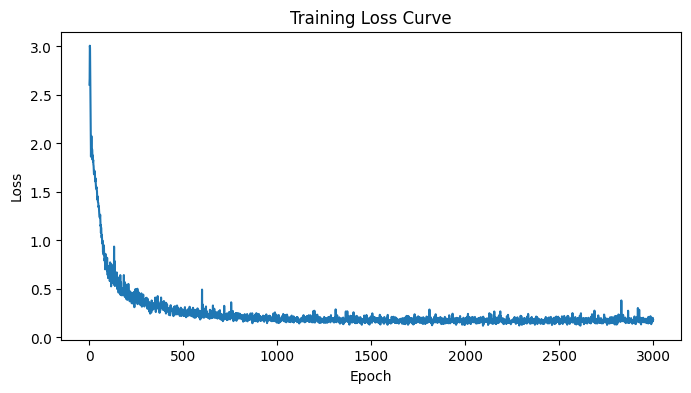

In [38]:
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

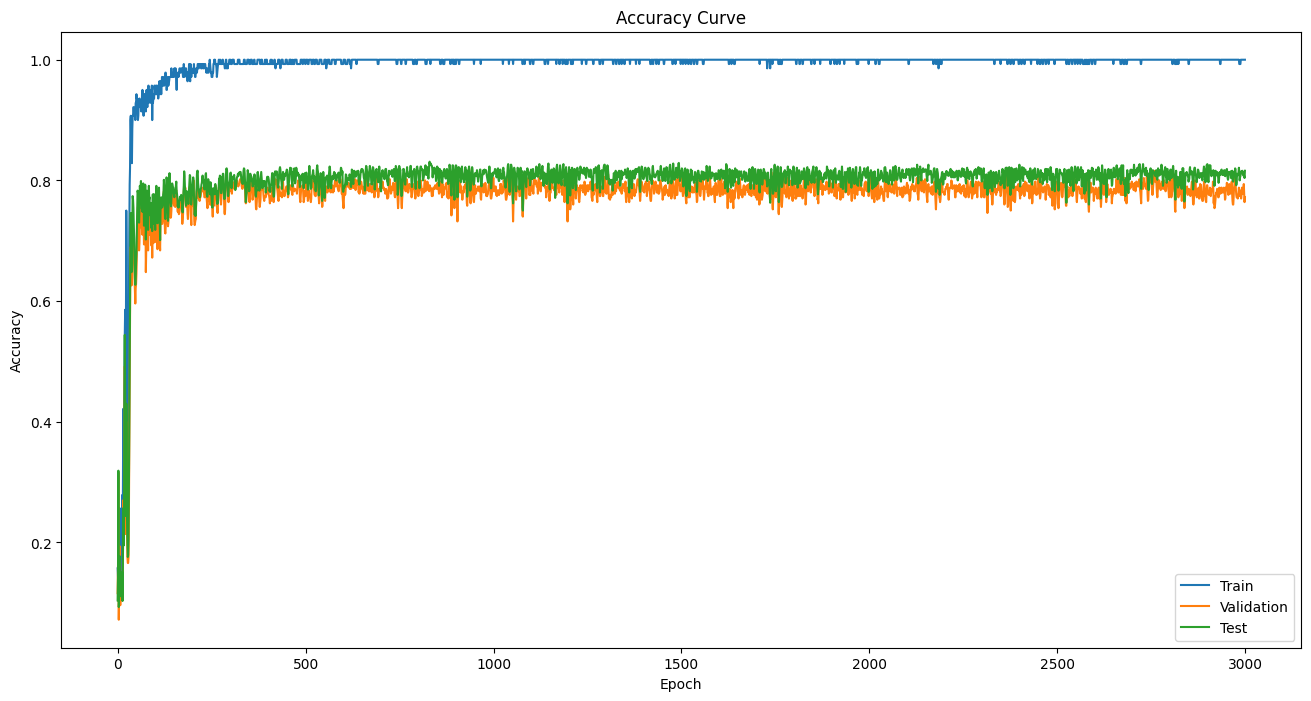

In [39]:
plt.figure(figsize=(16, 8))
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.plot(test_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend(['Train', 'Validation','Test'])
plt.show()

From the above model, we can see that the problem is from the construction of GCNLayer class. 

torch_geometric and dgl has different way constructing message passing, figure out why 